In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import linear_model
from sklearn.preprocessing import StandardScaler

from lampy import data
from lampy import metrics
from lampy.lstm import LSTM

In [2]:
data_file = 'data/636f6a2e-3a48-4801-afce-05c864adc60e-lampy_2019.csv'
sid = 'y7e4onsytkb3ydonflz5kcbcigkh5ulo'
target = 'pm10'
attributes = [target, 'o3', 'pm2p5', 'no2', 'so2']

df = data.read_2018_data(data_file).loc[sid, attributes]
resampled_df = data.resample_data(df, period='15T')
X, y = data.create_dataset(resampled_df)
X_tr, X_val, y_tr, y_val = data.train_validation_split(X, y)

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_tr_scaled = X_scaler.fit_transform(X_tr)
X_val_scaled = X_scaler.transform(X_val)

y_tr_scaled = y_scaler.fit_transform(y_tr)
y_val_scaled = y_scaler.transform(y_val)

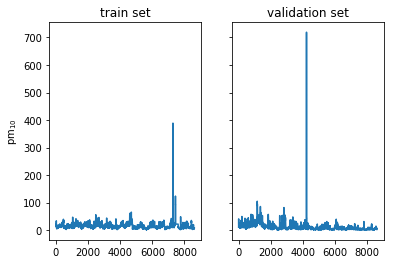

In [3]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.plot(y_tr)
ax1.set_ylabel('$\mathrm{pm}_{10}$')
ax1.set_title('train set')
ax2.plot(y_val)
ax2.set_title('validation set');

## Baseline

In [4]:
y_pred = X_val[:, :1]
baseline_rmse = metrics.rmse(y_val, y_pred)
print('baseline RMSE:', baseline_rmse)

baseline RMSE: 8.279020575239366


In [5]:
y_pred = X_tr[:, :1]
baseline_tr_rmse = metrics.rmse(y_tr, y_pred)
print('baseline train RMSE:', baseline_tr_rmse)

baseline train RMSE: 3.6933743519047977


## Lineární regrese

### Metoda nejmenších čtverců

In [6]:
linear = linear_model.LinearRegression()
linear.fit(X_tr, y_tr)

y_pred = linear.predict(X_val)

linear_rmse = metrics.rmse(y_val, y_pred)
print('linear RMSE:', linear_rmse)

print('coefs:', linear.coef_)

linear RMSE: 8.145235410655742
coefs: [[ 0.94737406 -0.01311821  0.01457445  0.01365614  0.00155432]]


In [7]:
y_pred = linear.predict(X_tr)
linear_tr_rmse = metrics.rmse(y_tr, y_pred)
print('linear train RMSE:', linear_tr_rmse)

linear train RMSE: 3.640641688055436


### Lasso

In [8]:
n_features = X_tr.shape[1]
columns = ['RMSE'] + ['coef ' + attribute for attribute in attributes]

n_alphas = 23
alphas = np.logspace(-10, 1, n_alphas)
lasso_stats = pd.DataFrame(index=alphas, columns=columns, dtype=np.float)

for alpha in alphas:
    lasso = linear_model.Lasso(alpha=alpha)
    lasso.fit(X_tr_scaled, y_tr_scaled)

    y_pred_scaled = lasso.predict(X_val_scaled)
    
    y_pred = y_scaler.inverse_transform(y_pred_scaled)
    lasso_rmse = metrics.rmse(y_val, y_pred)
    lasso_stats.loc[alpha] = (lasso_rmse, *lasso.coef_)

lasso_stats

,RMSE,coef pm10,coef o3,coef pm2p5,coef no2,coef so2
1.000000e-10,8.145235,0.947370,-0.016698,0.001962,0.019413,0.011029
3.162278e-10,8.145235,0.947370,-0.016698,0.001962,0.019413,0.011029
1.000000e-09,8.145235,0.947370,-0.016698,0.001962,0.019413,0.011029
3.162278e-09,8.145235,0.947370,-0.016698,0.001962,0.019413,0.011029
1.000000e-08,8.145235,0.947370,-0.016698,0.001962,0.019413,0.011029
3.162278e-08,8.145236,0.947370,-0.016698,0.001962,0.019413,0.011029
1.000000e-07,8.145236,0.947371,-0.016698,0.001961,0.019413,0.011029
3.162278e-07,8.145238,0.947372,-0.016698,0.001960,0.019412,0.011029
1.000000e-06,8.145244,0.947377,-0.016698,0.001955,0.019411,0.011028
3.162278e-06,8.145262,0.947391,-0.016697,0.001942,0.019408,0.011024


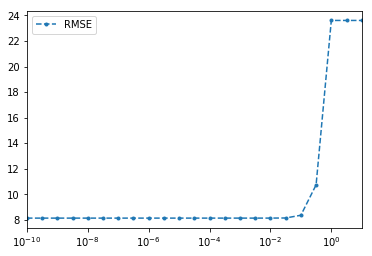

In [9]:
lasso_stats.plot(y='RMSE', logx=True, style='.--');

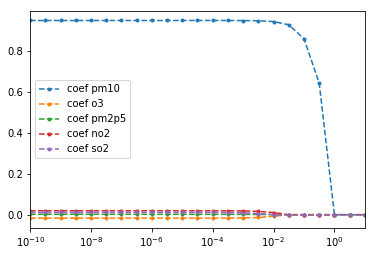

In [10]:
lasso_stats.plot(y=columns[1:], logx=True, style='.--');

## LSTM

In [11]:
lstm = LSTM(input_size=5, hidden_size=64, output_size=1)
lstm_stats = lstm.train(X_tr_scaled, y_tr_scaled, X_val_scaled, y_val_scaled,
                        n_epochs=50, seq_len=100)

epoch: 1 train loss: 0.6726067784181253 validation loss: 2.4838155394034356
epoch: 2 train loss: 0.5225756331473952 validation loss: 2.2997874593779017
epoch: 3 train loss: 0.4381071455452377 validation loss: 2.1632140149866528
epoch: 4 train loss: 0.3754305643929483 validation loss: 2.0605561691185006
epoch: 5 train loss: 0.3349674094038098 validation loss: 1.978078121373027
epoch: 6 train loss: 0.30715098187232254 validation loss: 1.9089484679665738
epoch: 7 train loss: 0.2851102794474663 validation loss: 1.8482855298282266
epoch: 8 train loss: 0.2661022889842963 validation loss: 1.7868242042421076
epoch: 9 train loss: 0.24986966585986925 validation loss: 1.752160882551358
epoch: 10 train loss: 0.23647241340225153 validation loss: 1.6938893664403436
epoch: 11 train loss: 0.22425858436873397 validation loss: 1.6865136900098654
epoch: 12 train loss: 0.21581688651524727 validation loss: 1.6287323819782962
epoch: 13 train loss: 0.20738808713503099 validation loss: 1.5948539599292015
epoc

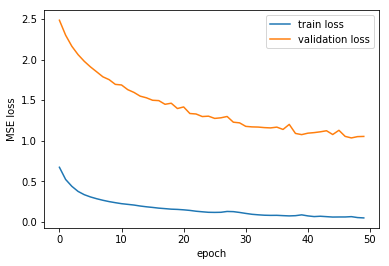

In [12]:
ax = plt.axes()
ax.plot(lstm_stats['tr_losses'], label='train loss')
ax.plot(lstm_stats['val_losses'], label='validation loss')
ax.set_xlabel('epoch')
ax.set_ylabel('MSE loss')
ax.legend();

In [13]:
y_pred_scaled = lstm.predict(X_val_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
lstm_rmse = metrics.rmse(y_val, y_pred)
lstm_rmse

13.083882760997426

In [14]:
y_pred_scaled = lstm.predict(X_tr_scaled)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
lstm_tr_rmse = metrics.rmse(y_tr, y_pred)
lstm_tr_rmse

2.928321503232652

## Results

In [15]:
# lasso show that other parameters are linearly unimportant
print('baseline RMSE:', baseline_rmse)
print('linear RMSE:  ', linear_rmse)
print('LSTM RMSE:    ', lstm_rmse)

baseline RMSE: 8.279020575239366
linear RMSE:   8.145235410655742
LSTM RMSE:     13.083882760997426


In [16]:
print('baseline train RMSE:', baseline_tr_rmse)
print('linear train RMSE:  ', linear_tr_rmse)
print('LSTM train RMSE:    ', lstm_tr_rmse)

baseline train RMSE: 3.6933743519047977
linear train RMSE:   3.640641688055436
LSTM train RMSE:     2.928321503232652
